In [4]:
## The following are few details about the approach taken to solve the problem:
## 1. I have used the data as is to predict into 5 classes and not a binary classification problem.

In [1]:
##Importing the essentiual libraries
import pandas as pd
import string
import numpy as np

In [2]:
## 1. Data Preparation
## 1.1 Data Preprocessing
reviews = pd.read_csv('amazon_reviews.csv')
reviews.reviewText = reviews.reviewText.fillna('NA')

In [3]:
def load_embedding_model():
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-300")
    print("loaded vocab size %i"% len(wv_from_bin.index_to_key))   
    return wv_from_bin

In [4]:
wv_from_bin = load_embedding_model()

loaded vocab size 400000


In [5]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ... ")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [6]:
from nltk.tokenize import RegexpTokenizer
def clean_data(corpus):
    print("Cleaning data ... ")
    cleaned_corpus = []
    for doc in corpus:
        tokenizer = RegexpTokenizer(r'\w+')
        cleaned_corpus.append(tokenizer.tokenize(doc.lower()))
    return cleaned_corpus

In [7]:
def get_vocab(corpus):
    corpus_words = [x for line in corpus for x in line]
    corpus_words = list(set(corpus_words))
    corpus_words = sorted(corpus_words)
    return corpus_words

In [8]:
get_vocab(["this is a great review", "this is a bad review"])

## test corpus

[' ', 'a', 'b', 'd', 'e', 'g', 'h', 'i', 'r', 's', 't', 'v', 'w']

In [9]:
def compute_co_occurence_matrix(corpus,window_size = 4):
    word2idx = {}
    print("Computing co-occurrence matrix...")
    print("Counting words...")
    sorted_corpus = get_vocab(corpus)
    for i in sorted_corpus:
        word2idx[i] = sorted_corpus.index(i)
    print(f"Number of unique words {len(sorted_corpus)}")
    x = len(sorted_corpus)
    M = np.zeros((x,x),dtype = 'float32')
    print(M.shape)
    print("Computing pairs...")
    for review in corpus:
        for i in range(len(review)):
            for j in range(max(0,i-window_size),min(i+window_size,len(review))):
                if i!=j:
                    M[word2idx[review[i]],word2idx[review[j]]] += 1
    return M,word2idx


In [10]:
from sklearn.decomposition import TruncatedSVD
def reduce_to_k_dim(M,k=2):
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    svd = TruncatedSVD(n_iter= 10, n_components=k, random_state=42)
    return svd.fit_transform(M)

In [11]:
from matplotlib import pyplot as plt
def plot_embeddings(M,word2index,words_to_plot):
    for w in words_to_plot:
        i = word2index[w]
        plt.scatter(M[i][0],M[i][1],marker='o',color='green')
        plt.annotate(w, (M[i][0],M[i][1]), arrowprops=dict(arrowstyle="->"))

In [12]:
corpus = reviews['reviewText'].fillna('').tolist()
corpus = clean_data(corpus)
vocab = get_vocab(corpus)
M,w2i = compute_co_occurence_matrix(corpus)
print(M.shape)

Cleaning data ... 
Computing co-occurrence matrix...
Counting words...
Number of unique words 8516
(8516, 8516)
Computing pairs...
(8516, 8516)


In [13]:
M = reduce_to_k_dim(M)

Running Truncated SVD over 8516 words...


In [14]:
M_2,w2i_2 = get_matrix_of_vectors(wv_from_bin,vocab)

Shuffling words ... 
Putting 10000 words into word2ind and matrix M...
Done.


In [15]:
M_2 = reduce_to_k_dim(M_2)

Running Truncated SVD over 16857 words...


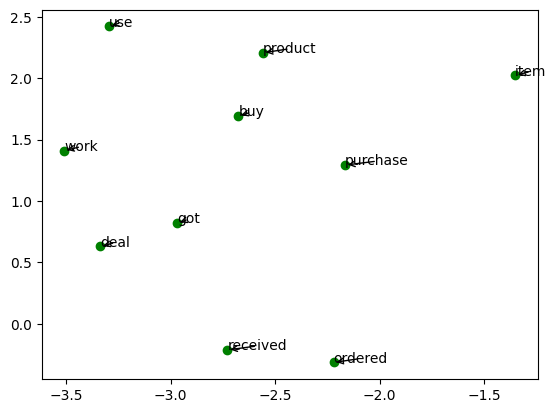

In [16]:
plot_embeddings(M_2,w2i_2,['purchase','buy','work','got','ordered','received','product','item','deal','use'])

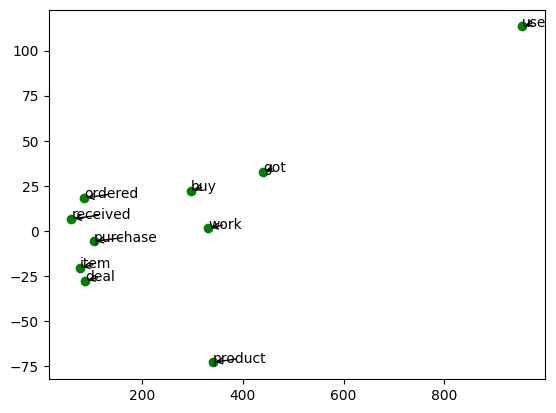

In [17]:
plot_embeddings(M,w2i,['purchase','buy','work','got','ordered','received','product','item','deal','use'])

In [18]:
def review_embeddings(corpus, word2index, M):

    M_reduced = reduce_to_k_dim(M,k = 128)
    print(f'Shape of the reduced matrix is {M_reduced.shape}')
    corpus_embeddings = []
    print("Computing corpus embeddings...")
    for review in corpus:
        corpus_embedding = np.mean([M_reduced[word2index[w]] for w in review],axis=0)
        corpus_embeddings.append(corpus_embedding)
    print("Done.")
    print(f"Shape of the corpus embeddings is {(np.array(corpus_embeddings).shape)}")
    return corpus_embeddings        

In [19]:
full_corpus = reviews['reviewText']
full_corpus = clean_data(full_corpus)

Cleaning data ... 


In [20]:
M,word2index = compute_co_occurence_matrix(full_corpus)
print(M.shape)
corpus_embeddings = review_embeddings(full_corpus,word2index,M)

Computing co-occurrence matrix...
Counting words...
Number of unique words 8516
(8516, 8516)
Computing pairs...
(8516, 8516)
Running Truncated SVD over 8516 words...
Shape of the reduced matrix is (8516, 128)
Computing corpus embeddings...
Done.
Shape of the corpus embeddings is (4915, 128)


In [21]:
X = np.array(corpus_embeddings)
y = reviews['overall']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

In [22]:
print('Total number of reviews for this product is: ', reviews.shape[0])
print('Number of reviews in training set is: ', X_train.shape[0])
print('Number of reviews in validation set is: ', X_val.shape[0])
print('Number of reviews in test set is: ', X_test.shape[0])

Total number of reviews for this product is:  4915
Number of reviews in training set is:  3932
Number of reviews in validation set is:  492
Number of reviews in test set is:  491


In [24]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression(solver='lbfgs' ,multi_class='ovr',max_iter=10000)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
y_pred = np.round(y_pred)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.7942973523421588


In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(128,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 10966 (42.84 KB)
Trainable params: 10966 (42.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val))
test_loss, test_acc = model.evaluate(X_test,y_test)
print('Test accuracy:', test_acc)

Epoch 1/100
123/123 [==============================] - 1s 3ms/step - loss: 69792.7109 - accuracy: 0.7828 - val_loss: 1.3237 - val_accuracy: 0.8008
Epoch 2/100
123/123 [==============================] - 0s 2ms/step - loss: 1.1806 - accuracy: 0.7988 - val_loss: 1.0614 - val_accuracy: 0.8008
Epoch 3/100
123/123 [==============================] - 0s 2ms/step - loss: 0.9916 - accuracy: 0.7988 - val_loss: 0.9313 - val_accuracy: 0.8008
Epoch 4/100
123/123 [==============================] - 0s 2ms/step - loss: 0.8982 - accuracy: 0.7988 - val_loss: 0.8661 - val_accuracy: 0.8008
Epoch 5/100
123/123 [==============================] - 0s 2ms/step - loss: 0.8502 - accuracy: 0.7988 - val_loss: 0.8314 - val_accuracy: 0.8008
Epoch 6/100
123/123 [==============================] - 0s 2ms/step - loss: 0.8235 - accuracy: 0.7988 - val_loss: 0.8111 - val_accuracy: 0.8008
Epoch 7/100
123/123 [==============================] - 0s 2ms/step - loss: 0.8075 - accuracy: 0.7988 - val_loss: 0.7986 - val_accuracy: 0.

In [ ]:
w

In [ ]:
reviews.head()

In [ ]:
X = reviews['reviewText']
y = reviews['overall']


In [ ]:
print('Total number of reviews for this profuct is: ', reviews.shape[0])
print('Number of reviews in training set is: ', X_train.shape[0])
print('Number of reviews in validation set is: ', X_val.shape[0])
print('Number of reviews in test set is: ', X_test.shape[0])